# Small box of water as a minimal test system
This is an attempt to isolate and replicate a problem I've been having with my SaltSwap code, namely, the erratic timings that occur between iterations of MD and MC salt insertions and deletions. The MC steps modify the non-bonded parameters of the context.

I only see erratic timings on a GPU and when MD and MC are used together. Not when MD or MC are used seperately. This notebook will try to replicate this behaviour.

In [1]:
import timeit
from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Using a small box of water as a test system:

In [2]:
size = 5.0
wbox = WaterBox(box_edge=size*unit.angstrom, cutoff=size/2*unit.angstrom, nonbondedMethod=app.PME)
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.002*unit.picoseconds)
context = openmm.Context(wbox.system, integrator)
context.setPositions(wbox.positions)
context.setVelocitiesToTemperature(300*unit.kelvin)
integrator.step(100)

Now modifying the non-bonded parameters, updating the parameters in context, and running more MD. 
Updating the parameters of the first water molecule by setting them to zero.

Making sure I've identified the correct forces to modify:

In [3]:
force = wbox.system.getForce(2)       # Non-bonded force.
for i in range(3):
    print force.getParticleParameters(i)

[Quantity(value=-0.834, unit=elementary charge), Quantity(value=0.3150752406575124, unit=nanometer), Quantity(value=0.635968, unit=kilojoule/mole)]
[Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]


Functions to modify context. These are nonequilibrium switching moves, meant only to test updating the context.

In [4]:
def switchoff(force,context,frac=0.9):
    force.setParticleParameters(0,charge=-0.834*frac,sigma=0.3150752406575124*frac,epsilon=0.635968*frac)
    force.setParticleParameters(1,charge=0.417*frac,sigma=0,epsilon=1*frac)
    force.setParticleParameters(2,charge=0.417*frac,sigma=0,epsilon=1*frac)
    force.updateParametersInContext(context)
    
def switchon(force,context):
    force.setParticleParameters(0,charge=-0.834,sigma=0.3150752406575124,epsilon=0.635968)
    force.setParticleParameters(1,charge=0.417,sigma=0,epsilon=1)
    force.setParticleParameters(2,charge=0.417,sigma=0,epsilon=1)
    force.updateParametersInContext(context)
    
def MDMC(force,context,integrator,steps,i):
    integrator.step(steps)
    if i % 2 == 0:
        switchoff(force,context)
    else:
        switchon(force,context)
        
def MC(force,context,i):
    if i % 2 == 0:
        switchoff(force,context)
    else:
        switchon(force,context)

# Global parameters for MD and MC iterations        
iterations = 200
nsteps = 500

## Timing MD

In [5]:
t_md = []
for i in range(iterations):
    t_md.append(timeit.timeit('integrator.step(nsteps)',setup="from __main__ import context, integrator,nsteps", number=1))    

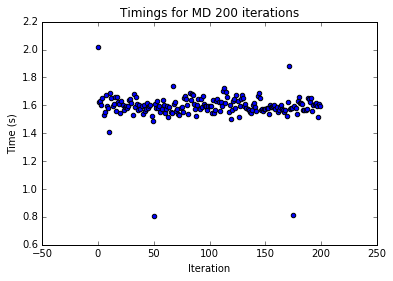

Percent fluctuation = 6.13


In [6]:
t_md = np.array(t_md)
plt.scatter(x=np.arange(iterations),y=t_md)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("Timings for MD {0} iterations".format(iterations))
plt.show()
print "Percent fluctuation = {0:.2f}".format(100*t_md.std()/t_md.mean())

## Timing MC

In [7]:
t_mc = []
for i in range(iterations):
    t_mc.append(timeit.timeit('MC(force,context,i)',setup="from __main__ import context,force,i, MC", number=1))    

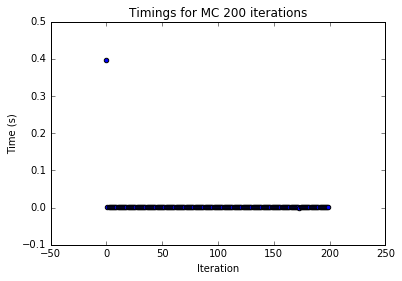

Percent fluctuation = 1168.08


In [8]:
t_mc = np.array(t_mc)
plt.scatter(x=np.arange(iterations),y=t_mc)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("Timings for MC {0} iterations".format(iterations))
plt.show()
print "Percent fluctuation = {0:.2f}".format(100*t_mc.std()/t_mc.mean())

## Timing MD and context manipulation

In [9]:
t_both = []
for i in range(iterations):
    t_both.append(timeit.timeit('MDMC(force,context,integrator,nsteps,i)',setup="from __main__ import MDMC, force, context, integrator, i,nsteps", number=1))

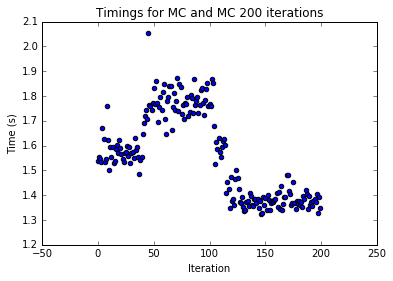

Percent fluctuation = 11.27


In [10]:
t_both = np.array(t_both)
plt.scatter(x=np.arange(iterations),y=t_both)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("Timings for MC and MC {0} iterations".format(iterations))
plt.show()
print "Percent fluctuation = {0:.2f}".format(100*t_both.std()/t_both.mean())